## Gradient Boosting Notebook

*currently in-progress* 

In [2]:
# Data Manipulation
# ======================================================
import pandas as pd 
import numpy as np
from os import path
import configparser
from itertools import *
import math
from epiweeks import Week
from datetime import date, datetime
from calendar import month_name, month_abbr
from sklearn import preprocessing
from helper_functions import *


# Reading Secrets
# ======================================================
cfg = configparser.ConfigParser()
cfg.read('secrets.ini')
ROOT_PATH = path.abspath(cfg.get('default','root'))
DATA_PATH = path.join(ROOT_PATH, 'src/data')


# Warnings Config
# ======================================================
import warnings
warnings.filterwarnings('ignore')

# Modeling & Forecasting
# ======================================================
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.regression.linear_model import OLS
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect

from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Plotting
# ======================================================
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# Loading & Manipulating Dataset
# ======================================================

df = pd.read_csv(path.join(DATA_PATH, 'raw_dataset.csv'))
df['epiweek'] = df['epiweek'].map(lambda x: Week.fromstring(str(x)))
df['weekstart'] = pd.to_datetime(df['epiweek'].map(lambda x: Week.startdate(x)))
df.set_index('weekstart', inplace=True)
df['epiweek'] = df['epiweek'].map(lambda x: int(str(x)[4:]))

In [4]:
# Checking dataset for missing values
df.isna().sum()

epiweek                0
GS_cold                0
GS_cough               0
GS_fever               0
GS_flu                 0
AWND                   0
PRCP                   0
SNOW                   0
TAVG                 398
TMAX                   0
TMIN                   0
cases                  0
Overall AQI Value      0
Main Pollutant         0
CO                    26
Ozone                113
PM10                  24
PM25                   0
Days Good              0
Days Moderate          0
Days Unhealthy         0
visits                79
dtype: int64

A number of variables contain missing values. Particularly concerning is TAVG - nearly half of the average temperature values are missing. This is related to the ways weather stations report temperatures. We are using data from the GR Gerald R Ford International Airport to represent Kent County, Michigan. This station stopped reporting average daily temperatures on 2005-08-07. The station resumed reporting average daily temperatures on 2013-03-31.

To address these missing values, we will average the daily maximum and daily minimum temperatures as an approximation of the daily average temperatures. For the other variables with missing values, we will input the corresponding monthly mean value.

In [5]:
means = df[['GS_cold', 'GS_cough', 'GS_fever', 'GS_flu', 
'AWND', 'PRCP', 'SNOW', 'TMAX', 'TMIN', 
'cases', 'Overall AQI Value',
'CO', 'Ozone', 'PM10', 'PM25', 'Days Good',
'Days Moderate', 'Days Unhealthy', 'visits']]\
    .groupby(df.index.month).mean()

means.index.name = 'month'

In [6]:
df['month'] = df.index.month

In [7]:
df = df.reset_index().set_index(['weekstart','month'])

In [8]:
df[
    ['GS_cold', 'GS_cough', 'GS_fever', 'GS_flu', 
    'AWND', 'PRCP', 'SNOW', 'TMAX', 'TMIN', 
    'cases', 'Overall AQI Value',
    'CO', 'Ozone', 'PM10', 'PM25', 'Days Good',
    'Days Moderate', 'Days Unhealthy', 'visits']
    ] = df[
        ['GS_cold', 'GS_cough', 'GS_fever', 'GS_flu', 
        'AWND', 'PRCP', 'SNOW', 'TMAX', 'TMIN', 
        'cases', 'Overall AQI Value',
        'CO', 'Ozone', 'PM10', 'PM25', 'Days Good',
        'Days Moderate', 'Days Unhealthy', 'visits']]\
            .fillna(means)

In [9]:
df['TAVG'] = df[['TAVG']].fillna(pd.DataFrame((df['TMAX']+df['TMIN'])/2).rename(columns={0:'TAVG'}))

In [10]:
df.isna().sum()

epiweek              0
GS_cold              0
GS_cough             0
GS_fever             0
GS_flu               0
AWND                 0
PRCP                 0
SNOW                 0
TAVG                 0
TMAX                 0
TMIN                 0
cases                0
Overall AQI Value    0
Main Pollutant       0
CO                   0
Ozone                0
PM10                 0
PM25                 0
Days Good            0
Days Moderate        0
Days Unhealthy       0
visits               0
dtype: int64

That looks better.

---

In [11]:
# Resampling data so pandas understands that it's weekly
df = df.reset_index().set_index('weekstart').drop(columns=['month']).resample('W').first().fillna(method='bfill')

In [12]:
end_train = date(2015,12,31)
end_validation = date(2017,12,31)

df_train = df.loc[:end_train,:]
df_val = df.loc[end_train:end_validation,:]
df_test = df.loc[end_validation:,:]

print(f"Dates train      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Dates validacion : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Dates test       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Dates train      : 2004-12-26 00:00:00 --- 2015-12-27 00:00:00  (n=575)
Dates validacion : 2016-01-03 00:00:00 --- 2017-12-31 00:00:00  (n=105)
Dates test       : 2017-12-31 00:00:00 --- 2019-12-29 00:00:00  (n=105)


In [13]:
# The weights are determined by total monthly cases divided by total overall cases
weights = pd.DataFrame((                
    df_train.groupby(df_train.index.month)['cases'].sum()\
    / df_train['cases'].sum()))\
    .reset_index().rename(columns={'weekstart':'month','cases':'weight'})\
    .set_index('month')

variables = ['GS_cold', 'GS_cough', 'GS_fever', 'GS_flu', 'AWND', 'PRCP',
            'SNOW', 'TAVG', 'TMAX', 'TMIN', 'Overall AQI Value','CO', 'Ozone', 
            'PM10', 'PM25', 'Days Good', 'Days Moderate',
            'Days Unhealthy', 'visits']

# Weighing by dividing exogenous variable values by their corresponding weight
w_df_train = df_train.drop(columns=['cases'])
w_df_train['month'] = w_df_train.index.month
w_df_train = w_df_train.reset_index().set_index(['month','weekstart'])
w_df_train = w_df_train[variables].join(weights)

w_df_train = w_df_train.reset_index().set_index('weekstart').drop(columns=['month'])

for c in variables:
    w_df_train[c] = w_df_train[c] / w_df_train['weight']

# Adding lagged variables with month-weighted values over 35% correlated with cases
for term in variables:
    for i in range(1,5):
        if abs(w_df_train[term].shift(i).corr(df_train['cases'])) >= 0.35:
            df[f"{term}_L{i}"] = df[term].shift(i)

In [14]:
df = df.iloc[2:,]

In [15]:
df_train = df.loc[:end_train,:]
df_val = df.loc[end_train:end_validation,:]
df_test = df.loc[end_validation:,:]

In [16]:
data = df.copy()
data['set'] = 0

In [17]:
data['set'].loc[:end_train] = 'train'
data['set'].loc[end_train:end_validation] = 'val'
data['set'].loc[end_validation:] = 'test'

In [18]:
data['month'] = data.index.month
data['month'] = data['month'].map(lambda x: month_abbr[x])

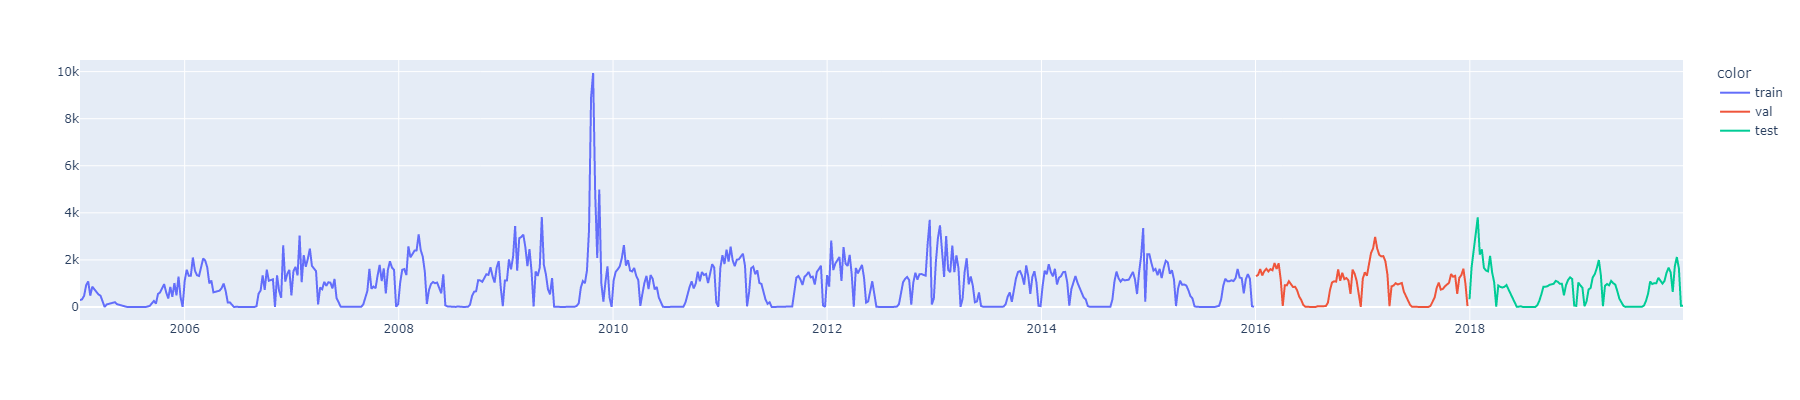

In [19]:
fig = px.line(x= data.index, y= data['cases'], color= data['set'])
fig.update_layout(autosize=False, width=1800, height=400)
fig.update_xaxes(title='')
fig.update_yaxes(title='')
fig.show('png')

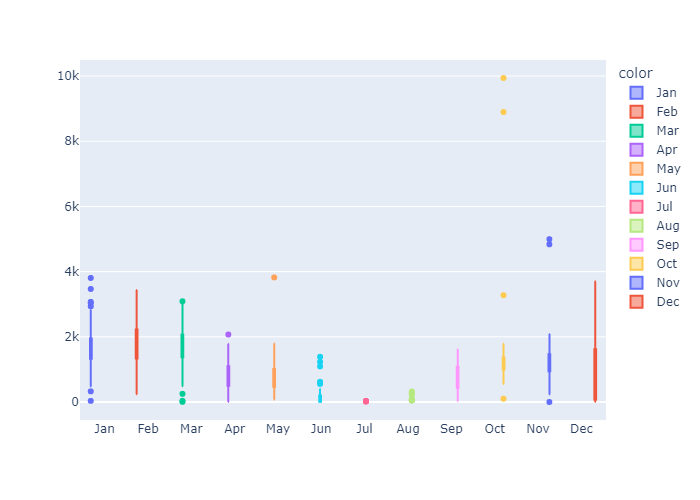

In [20]:
fig = px.box(x=data.iloc[1:,:]['month'], y=data.iloc[1:,:]['cases'], color=data.iloc[1:,:]['month'])
fig.update_layout(autosize=True)
fig.update_xaxes(title='')
fig.update_yaxes(title='')
fig.show('png')

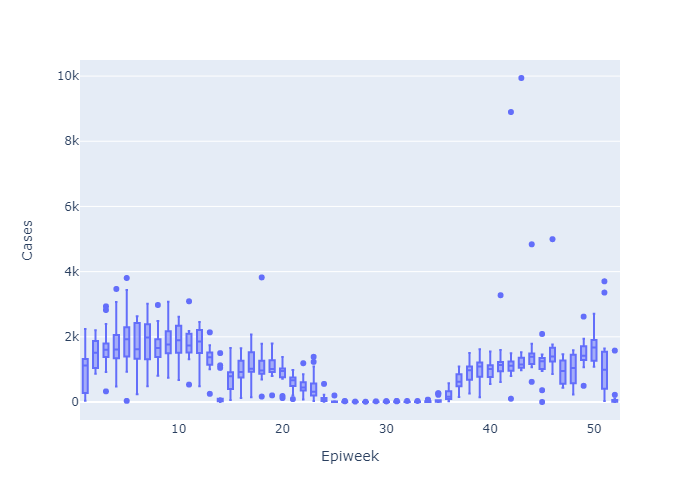

In [21]:
fig = px.box(x=data.iloc[1:,:]['epiweek'], y=data.iloc[1:,:]['cases'])
fig.update_layout(autosize=True)
fig.update_xaxes(title='Epiweek')
fig.update_yaxes(title='Cases')
fig.show('png')

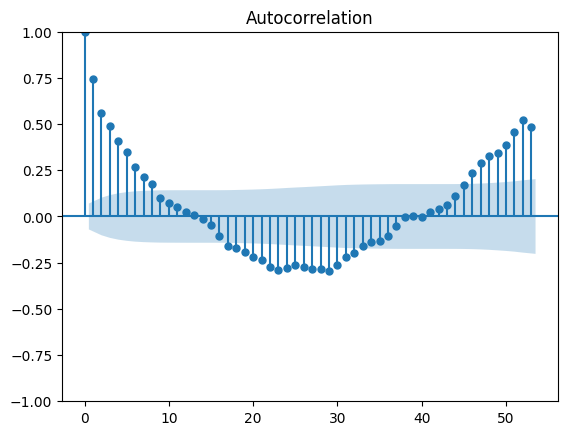

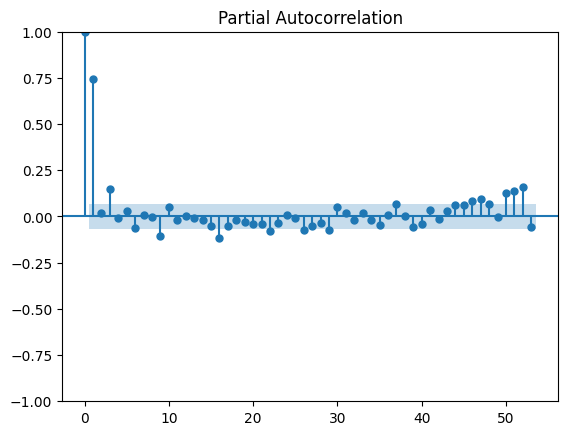

In [22]:
# Autocorrelation plots
plot_acf(data['cases'], lags=53).show()
plot_pacf(data['cases'], lags=53).show()

The autocorrelation plots demonstrate significant correlations between cases in previous weeks and cases in the future. This means we may be able to use lagged cases to predict future cases.

In [23]:
# Create baseline: cases of the same week of the previous year
# ==============================================================================

forecaster = ForecasterEquivalentDate(
                offset    = pd.DateOffset(weeks=52),
                n_offsets = 1
            )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.loc[:end_validation, 'cases'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: weeks=52> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 52 
Training range: [Timestamp('2005-01-09 00:00:00'), Timestamp('2017-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Creation date: 2024-01-22 13:35:44 
Last fit date: 2024-01-22 13:35:44 
Skforecast version: 0.11.0 
Python version: 3.11.5 
Forecaster id: None 

In [24]:
# Backtesting
# ==============================================================================
metric_baseline, predictions = backtesting_forecaster(
                                forecaster         = forecaster,
                                y                  = df['cases'],
                                steps              = 6,
                                metric             = 'mean_absolute_error',
                                initial_train_size = len(df.loc[:end_validation]),
                                refit              = False,
                                n_jobs             = 'auto',
                                verbose            = False,
                                show_progress      = True
                            )

print(f"Backtest error (MAE): {metric_baseline}")

100%|██████████| 18/18 [00:00<00:00, 68.06it/s]

Backtest error (MAE): 319.1442307692308


In [25]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=15926, verbose=-1),
                lags      = 52
            )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'cases'])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52] 
Transformer for y: None 
Transformer for exog: None 
Window size: 52 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2005-01-09 00:00:00'), Timestamp('2017-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'sub

In [26]:
# Predict
# ==============================================================================
forecaster.predict(steps=6)

2018-01-07    1759.788571
2018-01-14    1763.185649
2018-01-21    1819.362159
2018-01-28    2023.268130
2018-02-04    2112.593986
2018-02-11    2128.674061
Freq: W-SUN, Name: pred, dtype: float64

In [27]:
# Backtest model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data['cases'],
                        steps              = 6,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(data[:end_validation]),
                        refit              = False,
                        n_jobs             = 'auto',
                        verbose            = True, # Change to False to see less information
                        show_progress      = True
                    )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 678
Number of observations used for backtesting: 104
    Number of folds: 18
    Number of steps per fold: 6
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2005-01-09 00:00:00 -- 2017-12-31 00:00:00  (n=678)
    Validation: 2018-01-07 00:00:00 -- 2018-02-11 00:00:00  (n=6)
Fold: 1
    Training:   2005-01-09 00:00:00 -- 2017-12-31 00:00:00  (n=678)
    Validation: 2018-02-18 00:00:00 -- 2018-03-25 00:00:00  (n=6)
Fold: 2
    Training:   2005-01-09 00:00:00 -- 2017-12-31 00:00:00  (n=678)
    Validation: 2018-04-01 00:00:00 -- 2018-05-06 00:00:00  (n=6)
Fold: 3
    Training:   2005-01-09 00:00:00 -- 2017-12-31 00:00:00  (n=678)
    Validation: 2018-05-13 00:00:00 -- 2018-06-17 00:00:00  (n=6)
Fold: 4
    Training:   2005-01-09 00:00:00 -- 2017-12-31 00:00:00  (n=678)

100%|██████████| 18/18 [00:00<00:00, 33.69it/s]


,pred
2018-01-07,1759.788571
2018-01-14,1763.185649
2018-01-21,1819.362159
2018-01-28,2023.268130
2018-02-04,2112.593986


In [28]:
# Backtesting error
# ==============================================================================
print(f'Backtest error (MAE): {metric}')

Backtest error (MAE): 356.12001528241956


In [29]:
# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [[1,2,3], [1,2,3,52]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
                                forecaster         = forecaster,
                                y                  = df.loc[:end_validation, 'cases'], # Test data not used
                                search_space       = search_space,
                                lags_grid          = lags_grid,
                                steps              = 6,
                                refit              = False,
                                metric             = 'mean_absolute_error',
                                initial_train_size = len(df_train),
                                fixed_train_size   = False,
                                n_trials           = 20, # Increase this value for a more exhaustive search
                                random_state       = 123,
                                return_best        = True,
                                n_jobs             = 'auto',
                                verbose            = False,
                                show_progress      = True
                            )

Number of models compared: 40,
         20 bayesian search in each lag configuration.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

lags grid: 100%|██████████| 2/2 [00:48<00:00, 24.37s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 52] 
  Parameters: {'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.018066668056670537, 'reg_alpha': 0.8, 'reg_lambda': 0.0}
  Backtesting metric: 200.08392414618675



In [30]:
# Best model
# ==============================================================================
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.018066668056670537, max_depth=8,
              n_estimators=1200, random_state=15926, reg_alpha=0.8, verbose=-1) 
Lags: [ 1  2  3 52] 
Transformer for y: None 
Transformer for exog: None 
Window size: 52 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2005-01-09 00:00:00'), Timestamp('2017-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.018066668056670537, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1200, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.8, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin

In [31]:
# Backtest final model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = df['cases'],
                        steps              = 6,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(df[:end_validation]),
                        refit              = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = True
                    )

print(f"Backtest error: {metric:.2f}")
predictions.head()

100%|██████████| 18/18 [00:00<00:00, 39.87it/s]

Backtest error: 290.51


,pred
2018-01-07,1010.982367
2018-01-14,1526.586213
2018-01-21,1310.840594
2018-01-28,1670.403184
2018-02-04,2355.182652


In [32]:
px.line(df_test[['cases']].join(predictions).melt(ignore_index=False), y='value', color='variable')

---

*Let's try cyclically encoding epiweek*

In [33]:
epiweek_encoded = cyclical_encoding(df['epiweek'].apply(lambda x: x-1), cycle_length=52)

In [34]:
epiweek_encoded

,epiweek_sin,epiweek_cos
weekstart,,
2005-01-09,0.120537,0.992709
2005-01-16,0.239316,0.970942
2005-01-23,0.354605,0.935016
2005-01-30,0.464723,0.885456
2005-02-06,0.568065,0.822984
...,...,...
2019-12-01,-0.464723,0.885456
2019-12-08,-0.354605,0.935016
2019-12-15,-0.239316,0.970942


In [35]:
df = pd.concat([df, epiweek_encoded], axis=1)
df.head()

,epiweek,GS_cold,GS_cough,GS_fever,GS_flu,AWND,PRCP,SNOW,TAVG,TMAX,...,GS_fever_L2,AWND_L1,TAVG_L1,TAVG_L2,TMAX_L1,TMAX_L2,TMIN_L1,TMIN_L2,epiweek_sin,epiweek_cos
weekstart,,,,,,,,,,,,,,,,,,,,,
2005-01-09,2.0,2816.0,414.0,1048.0,707.0,11.142857,0.285714,0.428571,29.857143,36.000000,...,1023.0,8.428571,28.428571,28.285714,31.857143,36.571429,24.285714,19.714286,0.120537,0.992709
2005-01-16,3.0,3074.0,342.0,1057.0,720.0,12.142857,0.142857,2.142857,12.571429,17.714286,...,1047.0,11.142857,29.857143,28.428571,36.000000,31.857143,23.000000,24.285714,0.239316,0.970942
2005-01-23,4.0,3188.0,389.0,1062.0,782.0,7.285714,0.000000,0.000000,16.428571,26.857143,...,1048.0,12.142857,12.571429,29.857143,17.714286,36.000000,7.000000,23.000000,0.354605,0.935016
2005-01-30,5.0,2745.0,418.0,1083.0,897.0,5.000000,0.000000,0.000000,27.571429,36.285714,...,1057.0,7.285714,16.428571,12.571429,26.857143,17.714286,3.857143,7.000000,0.464723,0.885456
2005-02-06,6.0,3004.0,432.0,1257.0,986.0,7.714286,0.000000,0.000000,31.571429,37.142857,...,1062.0,5.000000,27.571429,16.428571,36.285714,26.857143,18.142857,3.857143,0.568065,0.822984


In [36]:
df['Main Pollutant'] = df['Main Pollutant'].astype('category')

In [37]:
df = pd.get_dummies(df).drop(columns=["Main Pollutant_['Ozone' 'PM2.5']"])

In [38]:
df = df.astype({col: np.float32 for col in df.select_dtypes("number").columns})

In [39]:
df_train = df.loc[:end_train,:]
df_val = df.loc[end_train:end_validation,:]
df_test = df.loc[end_validation:,:]

In [40]:
# Hyperparameters search
# ==============================================================================

# Create forecaster with a transformer categorical features
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=15926, verbose=-1),
                lags      = 52,
                fit_kwargs = {'categorical_feature':'auto'}
            )

# Lags grid
lags_grid = [[1,2,3], [1,2,3,52]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators' : trial.suggest_int('n_estimators', 800, 1400, step=100),
        'max_depth'    : trial.suggest_int('max_depth', 3, 8, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'    : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'   : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
                                forecaster         = forecaster,
                                y                  = df.loc[:end_validation, 'cases'],
                                exog               = df.loc[:end_validation,].drop(columns=['cases']),
                                search_space       = search_space,
                                lags_grid          = lags_grid,
                                steps              = 6,
                                refit              = False,
                                metric             = 'mean_absolute_error',
                                initial_train_size = len(df_train),
                                fixed_train_size   = False,
                                n_trials           = 20,
                                random_state       = 123,
                                return_best        = True,
                                n_jobs             = 'auto',
                                verbose            = False,
                                show_progress      = True
                            )

Number of models compared: 40,
         20 bayesian search in each lag configuration.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

lags grid: 100%|██████████| 2/2 [01:47<00:00, 53.59s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_estimators': 900, 'max_depth': 7, 'learning_rate': 0.01302331848344604, 'reg_alpha': 0.0, 'reg_lambda': 0.30000000000000004}
  Backtesting metric: 259.54085045221086



In [41]:
# Backtesting model with exogenous variables on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = df['cases'],
                        exog               = df.drop(columns=['cases']),
                        steps              = 6,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(df[:end_validation]),
                        refit              = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = True
                    )

print(f"Backtest error: {metric:.2f}")

100%|██████████| 18/18 [00:00<00:00, 30.50it/s]

Backtest error: 394.73


In [42]:
px.line(df_test[['cases']].join(predictions).melt(ignore_index=False), y='value', color='variable')

In [43]:
forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

,feature,importance
0,lag_1,1092
7,GS_flu,1006
22,visits,658
1,lag_2,646
3,epiweek,629
2,lag_3,616
14,Overall AQI Value,528
16,Ozone,345
35,epiweek_cos,331
6,GS_fever,326


---

In [44]:
# Underlying matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                    y    = df_train['cases'],
                    exog = df_train.drop(columns=['cases'])
                )

In [45]:
# Recursive feature elimination with cross-validation
# ==============================================================================
# Sample 50% of the data to speed up the calculation
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
y_train_sample = y_train.loc[sample]

regressor = LGBMRegressor(
                n_estimators = 100,
                max_depth    = 5,
                random_state = 15926,
                verbose      = -1
            )

selector = RFECV(
    estimator              = regressor,
    step                   = 1,
    cv                     = 3,
    min_features_to_select = 25,
    n_jobs                 = -1
)
selector.fit(X_train_sample, y_train_sample)
selected_features_rfe = selector.get_feature_names_out()

print("Recursive feature elimination")
print("-----------------------------")
print(f"Total number of features available: {X_train.shape[1]}") 
print(f"Total number of records available: {X_train.shape[0]}")
print(f"Total number of records used for feature selection: {X_train_sample.shape[0]}")
print(f"Number of features selected: {len(selected_features_rfe)}")
print(f"Selected features : \n {selected_features_rfe}")

Recursive feature elimination
-----------------------------
Total number of features available: 40
Total number of records available: 570
Total number of records used for feature selection: 285
Number of features selected: 25
Selected features : 
 ['lag_1' 'lag_2' 'lag_3' 'epiweek' 'GS_cold' 'GS_fever' 'GS_flu' 'AWND'
 'TAVG' 'TMIN' 'Overall AQI Value' 'Ozone' 'PM10' 'PM25' 'visits'
 'GS_cold_L1' 'GS_cold_L2' 'GS_fever_L1' 'GS_fever_L2' 'AWND_L1' 'TMAX_L2'
 'TMIN_L1' 'TMIN_L2' 'epiweek_sin' 'epiweek_cos']


In [46]:
# Create forecaster with the selected features
# ==============================================================================
params = {
    'n_estimators': 900, 
    'max_depth': 7, 
    'learning_rate': 0.022655,
    'reg_alpha': 0.8, 
    'reg_lambda': 0.2,
    'random_state': 15926,
    'verbose': -1
}

selected_lags = [
    int(feature.replace("lag_", ""))
    for feature in selected_features_rfe
    if feature.startswith("lag_")
]
selected_exog_features = [
    feature
    for feature in selected_features_rfe
    if not feature.startswith("lag_")
]

forecaster = ForecasterAutoreg(
                regressor        = LGBMRegressor(**params),
                lags             = selected_lags
            )

forecaster.fit(y=df_train['cases'], exog=df_train.drop(columns=['cases']))

# Backtesting model with exogenous variables on test data
# ==============================================================================
metric_lgbm, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = df['cases'],
                            exog               = df.drop(columns=['cases']),
                            steps              = 6,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(df[:end_validation]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error: {metric_lgbm:.2f}")

100%|██████████| 18/18 [00:00<00:00, 20.44it/s]


Backtest error: 414.62


In [52]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 52
            )

forecaster.fit(y=df_train['cases'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52] 
Transformer for y: None 
Transformer for exog: None 
Window size: 52 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2005-01-09 00:00:00'), Timestamp('2015-12-27 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'war

In [64]:
# Predictions
# ==============================================================================
steps = 105
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2016-01-03    1340.47
2016-01-10    1684.80
2016-01-17    1773.90
2016-01-24    1835.22
2016-01-31    1936.27
Freq: W-SUN, Name: pred, dtype: float64

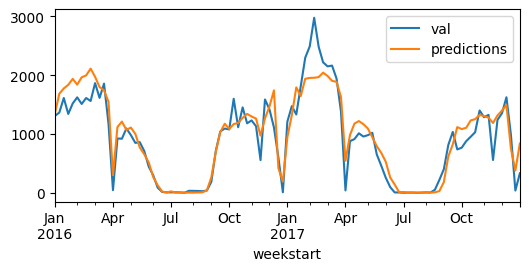

In [65]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
df_val['cases'].plot(ax=ax, label='val')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [66]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = df_val['cases'],
                y_pred = predictions
            )

print(f"Test error (MSE): {error_mse}")

Test error (MSE): 67045.27223333334
